# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參數設定

In [1]:
HORIZON = 1 # 0: 預設當日、1: 預測隔日(原本深度學習)，程式寫法僅支援 0,1

predict_types = [1]
fieldName = 'GroupCount'

# predict_types = [1]
# fieldName = 'GroupCount'

# training_window = @training_window@ # 過去天數，用於訓練資料中的歷史資料長度
# predict_type = @predict_type@
# fieldName = '@label_column@' 

# ==== 底下的參數基本上都不要亂動 ====
training_window = 14  # 過去天數，用於訓練資料中的歷史資料長度 
train_split_rate = 0.04  # 訓練集佔整體資料集的比例
# includeTraingData = False  # 資料來源是否包含訓練集最後 14 天，正常要包含，但有少數一些資料會有問題，若遇到有問題，把這個改成 False
 

actFiledName = fieldName 
if HORIZON == 1:
    actFiledName = f'{actFiledName}1'
    
model_dir = 'ARIMA/_Model'

# 定義類別

In [2]:
# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import ArimaLib 
importlib.reload(ArimaLib)   

from ArimaLib import * 
arima = ArimaLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
result_file_name = arima.reset_data(
    model_dir, 
    label_name = fieldName, 
    predicteds = predict_types
)

result_file_name: ARIMA/_Model/GroupCount_data1.result.json


# 載入數據

In [4]:
arima_data = arima.load_data(predict_types)[[fieldName]]
arima_data

# 載入數據


,GroupCount
RequestTime,
2023-04-02,9923
2023-04-03,13065
2023-04-04,14207
2023-04-05,15636
2023-04-06,38862
...,...
2024-04-26,20652
2024-04-27,13194
2024-04-28,12238


# 切割訓練和測試資料集

In [5]:
train_data, test_data = arima.split_train_test_data(arima_data, train_split_rate)
# train_data, test_data = arima.split_train_test_data2(arima_data, training_window=training_window)

# 切割訓練和測試資料集，split rate 0.04
這裡切割訓練和測試跟深度學習不同，這裡只是單純的要切割測試資料集區間，實際上並沒有用到訓練集
data length: 395
train_data.shape: (15, 1)
test_data.shape: (380, 1)


# 原始資料視覺化

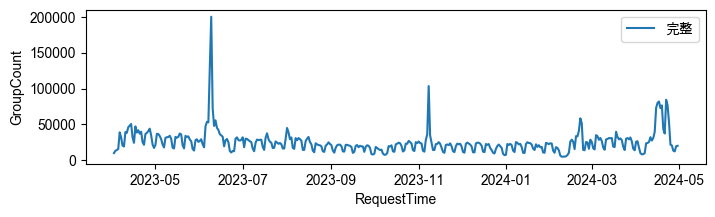

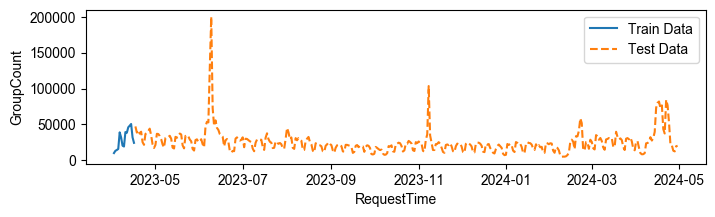

In [6]:
plt.figure(figsize=(8, 2))
plt.plot(arima_data.index, arima_data[fieldName], label='完整')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(train_data.index, train_data[fieldName], label='Train Data')
plt.plot(test_data.index, test_data[fieldName], label='Test Data', linestyle='--')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

# 找出最佳參數

In [7]:
# if includeTraingData:
#     print(f'使用訓練集前 {training_window} 天')
#     aic_data = [x for x in train_data[fieldName]]
#     aic_data = aic_data[(-training_window):] 
#     aic_data.extend(test_data[fieldName].values) 
# else:
#     print(f'不使用訓練集前 {training_window} 天')
#     aic_data = test_data[fieldName].values

aic_data = arima_data[fieldName].values
print(len(aic_data))

auto_model, best_p, best_d, best_q, best_aic, arima_resid, best_ar_pvalue, best_ma_pvalue = \
    arima.find_best_config(aic_data, window_size=training_window)
# 基本上選出來的 P-Vaule 都要小於 0.05，才達到顯著的效果，代表是平穩的序列

395
# 找到最佳的 p, d, q 值，window_size: 14 



Best model:  ARIMA(8,1,10)(0,0,0)[0] intercept
Total fit time: 40.146 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:              SARIMAX(8, 1, 10)   Log Likelihood               -4208.750
Date:                Thu, 19 Jun 2025   AIC                           8457.500
Time:                        10:57:18   BIC                           8537.027
Sample:                             0   HQIC                          8489.013
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.8288     73.643      0.201      0.840    -129.508     159.166
ar.L1          0.4758      0.794      0.599      0.5

# 使用 ARMIA 套件再次驗證

In [8]:
model_summary_fit = arima.check_arima_model(aic_data, best_p, best_d, best_q)

# 檢查 ARIMA 模型


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:                ARIMA(8, 1, 10)   Log Likelihood               -4208.471
Date:                Thu, 19 Jun 2025   AIC                           8454.943
Time:                        10:57:19   BIC                           8530.493
Sample:                             0   HQIC                          8484.879
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4973      1.375      0.362      0.718      -2.197       3.192
ar.L2         -0.0467      0.324     -0.144      0.885      -0.682       0.588
ar.L3         -0.1616      0.295     -0.548      0.5

# Shift 預測資料

In [9]:
test_shifted = arima.shift_data(test_data, fieldName, HORIZON)
test_shifted.head()
print(len(test_shifted))

# 整理預測未來的資料
380


# 執行預測

In [10]:
test_ts, predictions = arima.predict(
    train_data, test_shifted, 
    field_name=fieldName, 
    act_field_name=actFiledName,
    best_d=best_d,
    best_p=best_p,
    best_q=best_q,
    training_window=training_window,
    horizon=HORIZON
)

# 開始預測
第一個預測日 :  2023-04-17 00:00:00
第一個預測日，前 {training_window} 日數據 :               GroupCount
RequestTime            
2023-04-03        13065
2023-04-04        14207
2023-04-05        15636
2023-04-06        38862
2023-04-07        31772
2023-04-08        20238
2023-04-09        19085
2023-04-10        39217
2023-04-11        38250
2023-04-12        45895
2023-04-13        48103
2023-04-14        50519
2023-04-15        31795
2023-04-16        24193
第一個預測日當日 :  47117.0
第一個預測日隔日 :  38519.0
第一個預測日，前 {training_window} 日數據 :  [9923, 13065, 14207, 15636, 38862, 31772, 20238, 19085, 39217, 38250, 45895, 48103, 50519, 31795, 24193]
最佳的 p 值: 8
最佳的 d 值: 1
最佳的 q 值: 10
-------------------------------------------------------
-------------------------------------------------------

yhat: [24917.87922986 30992.41911814]
( 0). 實際 : 38519.0 預測 : 30992.419118139755 差距 : 7526.580881860245


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


yhat: [55529.02567069 50766.61251534]
( 1). 實際 : 41804.0 預測 : 50766.61251534312 差距 : -8962.61251534312
yhat: [40147.72632764 47753.34185044]
( 2). 實際 : 37041.0 預測 : 47753.34185043873 差距 : -10712.34185043873
yhat: [47930.90678968 59645.9015947 ]
( 3). 實際 : 39725.0 預測 : 59645.901594704796 差距 : -19920.901594704796


yhat: [58624.61466944 34415.84437729]
( 4). 實際 : 25155.0 預測 : 34415.84437728865 差距 : -9260.844377288653
yhat: [34252.29898351 16901.78969031]
( 5). 實際 : 21423.0 預測 : 16901.78969030959 差距 : 4521.21030969041


yhat: [20188.87152434 47937.90892978]
( 6). 實際 : 36611.0 預測 : 47937.90892978138 差距 : -11326.908929781377
yhat: [47211.89493739 33168.99377199]
( 7). 實際 : 38107.0 預測 : 33168.99377198683 差距 : 4938.006228013168


yhat: [37814.36891313 31267.46192817]
( 8). 實際 : 40559.0 預測 : 31267.461928169505 差距 : 9291.538071830495
yhat: [33696.61081466 33051.90043958]
( 9). 實際 : 44003.0 預測 : 33051.90043957646 差距 : 10951.099560423543
yhat: [31647.41402198 34888.95211573]
(10). 實際 : 34605.0 預測 : 34888.95211573178 差距 : -283.9521157317795


yhat: [40738.02960243 30652.54462608]
(11). 實際 : 22026.0 預測 : 30652.54462608162 差距 : -8626.54462608162
yhat: [26940.53057263 20093.50624407]
(12). 實際 : 17053.0 預測 : 20093.506244074684 差距 : -3040.506244074684


yhat: [16156.30029394 25215.18301903]
(13). 實際 : 21285.0 預測 : 25215.18301903235 差距 : -3930.183019032349
yhat: [26046.36858895 36914.7523902 ]
(14). 實際 : 36805.0 預測 : 36914.75239019925 差距 : -109.75239019925357


yhat: [31588.1675358  42496.67323699]
(15). 實際 : 36528.0 預測 : 42496.673236988834 差距 : -5968.673236988834
yhat: [46402.83848455 55230.68969075]
(16). 實際 : 33698.0 預測 : 55230.6896907504 差距 : -21532.689690750398


yhat: [55678.38204855 34455.83507257]
(17). 實際 : 29386.0 預測 : 34455.83507257121 差距 : -5069.835072571208
yhat: [30222.36687997  7794.97495266]
(18). 實際 : 21939.0 預測 : 7794.974952657129 差距 : 14144.025047342871


yhat: [6959.60592039 6718.33875335]
(19). 實際 : 17716.0 預測 : 6718.338753347343 差距 : 10997.661246652657
yhat: [ 9513.20025144 17412.41678255]
(20). 實際 : 31090.0 預測 : 17412.416782547538 差距 : 13677.583217452462


yhat: [25932.89840823 46274.76405178]
(21). 實際 : 32057.0 預測 : 46274.76405178305 差距 : -14217.764051783051
yhat: [49919.38941651 47659.64365933]
(22). 實際 : 32282.0 預測 : 47659.643659329915 差距 : -15377.643659329915


yhat: [44062.33776283 36721.18694406]
(23). 實際 : 34092.0 預測 : 36721.18694406336 差距 : -2629.18694406336
yhat: [21481.21077612  9635.14571699]
(24). 實際 : 29939.0 預測 : 9635.145716993375 差距 : 20303.854283006625


yhat: [25236.59864586 28272.56401633]
(25). 實際 : 17451.0 預測 : 28272.56401633453 差距 : -10821.56401633453
yhat: [31994.31224024 22003.16109069]
(26). 實際 : 16334.0 預測 : 22003.161090690242 差距 : -5669.161090690242
yhat: [27085.69339874 31306.87501386]
(27). 實際 : 32529.0 預測 : 31306.87501385549 差距 : 1222.1249861445103


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


yhat: [-3637478.16698462  4360945.00765207]
(28). 實際 : 31443.0 預測 : 4360945.007652074 差距 : -4329502.007652074
yhat: [32457.7485534  35582.92294964]
(29). 實際 : 32548.0 預測 : 35582.92294964136 差距 : -3034.922949641361


yhat: [25798.22305614 33022.18678522]
(30). 實際 : 37228.0 預測 : 33022.1867852163 差距 : 4205.813214783702
yhat: [33140.65853075 23202.93665892]
(31). 實際 : 35912.0 預測 : 23202.93665891922 差距 : 12709.063341080779


yhat: [29150.39121542  8162.37048336]
(32). 實際 : 20683.0 預測 : 8162.370483362534 差距 : 12520.629516637466
yhat: [26256.67081535 24791.33346894]
(33). 實際 : 16484.0 預測 : 24791.333468936864 差距 : -8307.333468936864


yhat: [3.07545087e+22 9.35554815e+22]
(34). 實際 : 33919.0 預測 : 9.355548146581055e+22 差距 : -9.355548146581055e+22
yhat: [28799.08065254 31767.74873702]
(35). 實際 : 32520.0 預測 : 31767.74873702448 差距 : 752.2512629755183


yhat: [39205.83969174 34539.8705701 ]
(36). 實際 : 33245.0 預測 : 34539.8705700973 差距 : -1294.8705700973005
yhat: [31685.5813656 36334.2633779]
(37). 實際 : 28808.0 預測 : 36334.2633778959 差距 : -7526.263377895899


yhat: [33990.25546819 30170.44294514]
(38). 實際 : 26356.0 預測 : 30170.442945141698 差距 : -3814.442945141698
yhat: [33208.27367947 20307.54258518]
(39). 實際 : 15593.0 預測 : 20307.542585177805 差距 : -4714.542585177805


yhat: [20891.27432892 13369.58867948]
(40). 實際 : 13439.0 預測 : 13369.588679482578 差距 : 69.4113205174217
yhat: [ 9802.44587654 25673.66081858]
(41). 實際 : 28047.0 預測 : 25673.660818575427 差距 : 2373.3391814245733


yhat: [26901.22080249 29675.5137021 ]
(42). 實際 : 29102.0 預測 : 29675.513702104698 差距 : -573.5137021046976
yhat: [31118.87016335 35944.5056054 ]
(43). 實際 : 25529.0 預測 : 35944.505605395716 差距 : -10415.505605395716


yhat: [34072.66731732 30472.70391442]
(44). 實際 : 26819.0 預測 : 30472.70391441965 差距 : -3653.7039144196497
yhat: [25521.33364007 25826.65954368]
(45). 實際 : 29215.0 預測 : 25826.659543679834 差距 : 3388.3404563201657


yhat: [27849.02189091 18011.72720665]
(46). 實際 : 22276.0 預測 : 18011.727206654352 差距 : 4264.272793345648
yhat: [16693.7495335  17594.83825498]
(47). 實際 : 17925.0 預測 : 17594.838254983304 差距 : 330.16174501669593


yhat: [21956.53561218 29899.65092611]
(48). 實際 : 47254.0 預測 : 29899.65092610981 差距 : 17354.34907389019
yhat: [28333.39324086 33063.22082397]
(49). 實際 : 53567.0 預測 : 33063.22082397302 差距 : 20503.779176026983


yhat: [36853.62990947 28719.10329686]
(50). 實際 : 52761.0 預測 : 28719.103296856465 差距 : 24041.896703143535
yhat: [39486.04133335 45498.02658784]
(51). 實際 : 129828.0 預測 : 45498.02658784157 差距 : 84329.97341215843


yhat: [51193.6765024  50657.63080126]
(52). 實際 : 200222.0 預測 : 50657.63080125904 差距 : 149564.36919874095
yhat: [160218.34810476 192390.66804459]
(53). 實際 : 72469.0 預測 : 192390.66804459493 差距 : -119921.66804459493


yhat: [285936.01611484 499307.34204107]
(54). 實際 : 47850.0 預測 : 499307.3420410701 差距 : -451457.3420410701


yhat: [-27251.61271568 149816.9555513 ]
(55). 實際 : 55592.0 預測 : 149816.9555513028 差距 : -94224.95555130279


yhat: [253495.36147601 192992.07700428]
(56). 實際 : 45133.0 預測 : 192992.07700427558 差距 : -147859.07700427558


yhat: [-76820.31079219 -90985.93530733]
(57). 實際 : 42200.0 預測 : -90985.93530733365 差距 : 133185.93530733365


yhat: [ 41318.05966787 163815.236187  ]
(58). 實際 : 36338.0 預測 : 163815.23618699625 差距 : -127477.23618699625


yhat: [199377.26015455 230347.38231598]
(59). 實際 : 34525.0 預測 : 230347.3823159785 差距 : -195822.3823159785


yhat: [85591.8736293  34746.55709053]
(60). 實際 : 32811.0 預測 : 34746.55709053161 差距 : -1935.5570905316126


yhat: [-36047.62256938 -32173.21018187]
(61). 實際 : 19331.0 預測 : -32173.21018186664 差距 : 51504.21018186664


yhat: [-8588.41392762 12580.12880906]
(62). 實際 : 27695.0 預測 : 12580.128809062808 差距 : 15114.871190937192


yhat: [64749.1413865  79247.28004146]
(63). 實際 : 29529.0 預測 : 79247.28004145733 差距 : -49718.28004145733


yhat: [49964.87105966 17241.99072393]
(64). 實際 : 25178.0 預測 : 17241.99072393462 差距 : 7936.009276065379


yhat: [ 4240.99571185 44981.11675345]
(65). 實際 : 12713.0 預測 : 44981.11675344658 差距 : -32268.11675344658


yhat: [56580.79204031 72683.95358369]
(66). 實際 : 10769.0 預測 : 72683.95358369488 差距 : -61914.95358369488


yhat: [23701.42447582 21533.51368829]
(67). 實際 : 12887.0 預測 : 21533.513688288585 差距 : -8646.513688288585


yhat: [  3798.91628738 -11701.4848889 ]
(68). 實際 : 12546.0 預測 : -11701.484888901008 差距 : 24247.48488890101


yhat: [ 2463.66240975 10459.99418839]
(69). 實際 : 30103.0 預測 : 10459.994188389888 差距 : 19643.005811610114


yhat: [21082.91346139 25651.42979515]
(70). 實際 : 31876.0 預測 : 25651.429795154414 差距 : 6224.570204845586


yhat: [34069.92388932 18024.63973884]
(71). 實際 : 28045.0 預測 : 18024.639738843005 差距 : 10020.360261156995


yhat: [15689.03933635 31877.63726589]
(72). 實際 : 27290.0 預測 : 31877.637265885925 差距 : -4587.637265885925


yhat: [45623.29239212 52124.88046163]
(73). 實際 : 28426.0 預測 : 52124.88046162941 差距 : -23698.880461629407


yhat: [40198.34628504 32304.61556028]
(74). 實際 : 31879.0 預測 : 32304.61556028219 差距 : -425.6155602821891


yhat: [21461.1446795  23591.64564661]
(75). 實際 : 18086.0 預測 : 23591.64564660871 差距 : -5505.645646608711


yhat: [34266.37264902 43649.21677138]
(76). 實際 : 29962.0 預測 : 43649.216771377854 差距 : -13687.216771377854


yhat: [27579.07154853 41389.25010493]
(77). 實際 : 29604.0 預測 : 41389.25010493322 差距 : -11785.25010493322


yhat: [38652.51635239 23563.95956908]
(78). 實際 : 27949.0 預測 : 23563.95956907878 差距 : 4385.040430921221


yhat: [21186.59896624 28728.95067371]
(79). 實際 : 26382.0 預測 : 28728.95067371341 差距 : -2346.9506737134107


yhat: [30821.02065426 48327.30554388]
(80). 實際 : 25297.0 預測 : 48327.30554388327 差距 : -23030.305543883267


yhat: [42028.86962251 31240.15385403]
(81). 實際 : 16118.0 預測 : 31240.15385403228 差距 : -15122.15385403228


yhat: [17816.09363274 13262.86978221]
(82). 實際 : 12474.0 預測 : 13262.869782205315 差距 : -788.8697822053146


yhat: [14874.53183525 24786.43404784]
(83). 實際 : 24352.0 預測 : 24786.43404784188 差距 : -434.4340478418817


yhat: [21479.12484652 32522.91123863]
(84). 實際 : 28786.0 預測 : 32522.911238632318 差距 : -3736.9112386323177


yhat: [34831.18030785 23488.39124767]
(85). 實際 : 27978.0 預測 : 23488.391247666717 差距 : 4489.608752333283


yhat: [18323.31147677 31090.89181967]
(86). 實際 : 28488.0 預測 : 31090.89181966919 差距 : -2602.8918196691884


yhat: [43249.23238396 50138.76086587]
(87). 實際 : 28533.0 預測 : 50138.76086587157 差距 : -21605.76086587157


yhat: [37901.92487239 37325.80223506]
(88). 實際 : 18374.0 預測 : 37325.80223506454 差距 : -18951.80223506454


yhat: [26363.93966998 17479.66965778]
(89). 實際 : 14331.0 預測 : 17479.669657778017 差距 : -3148.6696577780167


yhat: [10106.95707479 26500.40475034]
(90). 實際 : 31302.0 預測 : 26500.404750343867 差距 : 4801.595249656133


yhat: [28878.70648773 33222.10554774]
(91). 實際 : 37521.0 預測 : 33222.105547735715 差距 : 4298.894452264285


yhat: [31000.58612143 23112.76077714]
(92). 實際 : 29485.0 預測 : 23112.760777144482 差距 : 6372.239222855518


yhat: [29212.05654224 29442.738497  ]
(93). 實際 : 25726.0 預測 : 29442.73849700147 差距 : -3716.738497001468


yhat: [33182.01196932 45601.03191159]
(94). 實際 : 24411.0 預測 : 45601.03191158975 差距 : -21190.03191158975


yhat: [39268.20746917 27977.1207097 ]
(95). 實際 : 16887.0 預測 : 27977.120709699317 差距 : -11090.120709699317


yhat: [16780.26902526 11620.40036052]
(96). 實際 : 17319.0 預測 : 11620.400360522166 差距 : 5698.599639477834


yhat: [11175.77344838 22240.63196403]
(97). 實際 : 26220.0 預測 : 22240.63196403359 差距 : 3979.3680359664104


yhat: [27228.18891505 38548.52688198]
(98). 實際 : 24536.0 預測 : 38548.52688198304 差距 : -14012.526881983038


yhat: [37577.60577991 30308.88607693]
(99). 實際 : 22850.0 預測 : 30308.88607692927 差距 : -7458.88607692927


yhat: [16984.23694339 25525.36469381]
(100). 實際 : 23972.0 預測 : 25525.36469380714 差距 : -1553.3646938071397


yhat: [28822.7281945  32525.09962676]
(101). 實際 : 22291.0 預測 : 32525.099626757183 差距 : -10234.099626757183


yhat: [30197.00526472 26546.23085384]
(102). 實際 : 16327.0 預測 : 26546.230853843346 差距 : -10219.230853843346


yhat: [18911.8488227  10270.04066587]
(103). 實際 : 16181.0 預測 : 10270.040665869315 差距 : 5910.9593341306845


yhat: [ 8548.62234432 20714.47086981]
(104). 實際 : 29654.0 預測 : 20714.470869813107 差距 : 8939.529130186893


yhat: [28421.51848705 34203.35139972]
(105). 實際 : 44963.0 預測 : 34203.35139971637 差距 : 10759.648600283632


yhat: [36498.04817687 30226.84476561]
(106). 實際 : 38937.0 預測 : 30226.844765605543 差距 : 8710.155234394457


yhat: [38430.99928915 28619.65640184]
(107). 實際 : 29355.0 預測 : 28619.656401839824 差距 : 735.343598160176


yhat: [29137.94157001 32608.10402135]
(108). 實際 : 31731.0 預測 : 32608.104021352447 差距 : -877.1040213524466


yhat: [32566.3316953  26646.14332155]
(109). 實際 : 17202.0 預測 : 26646.14332154796 差距 : -9444.14332154796


yhat: [26046.18853121 16511.58190236]
(110). 實際 : 15778.0 預測 : 16511.581902361162 差距 : -733.5819023611621


yhat: [ 8609.78524453 21803.18990075]
(111). 實際 : 30801.0 預測 : 21803.18990075166 差距 : 8997.810099248341


yhat: [27273.04198416 38814.44966114]
(112). 實際 : 27804.0 預測 : 38814.4496611433 差距 : -11010.449661143299


yhat: [41571.76348333 33155.99706022]
(113). 實際 : 30891.0 預測 : 33155.997060222595 差距 : -2264.997060222595


yhat: [21458.17060596 23774.30446285]
(114). 實際 : 29299.0 預測 : 23774.304462847234 差距 : 5524.695537152766


yhat: [30897.49051793 29486.80374425]
(115). 實際 : 27290.0 預測 : 29486.80374425091 差距 : -2196.8037442509085


yhat: [27230.7125394  23416.79640525]
(116). 實際 : 14345.0 預測 : 23416.796405245255 差距 : -9071.796405245255


yhat: [22803.57547973 15010.75258249]
(117). 實際 : 14353.0 預測 : 15010.752582490577 差距 : -657.752582490577


yhat: [ 7261.28556573 20687.72327739]
(118). 實際 : 26630.0 預測 : 20687.72327738505 差距 : 5942.276722614952


yhat: [27448.24686721 36840.05668679]
(119). 實際 : 30014.0 預測 : 36840.05668678865 差距 : -6826.056686788652


yhat: [36499.42183891 31682.09671712]
(120). 實際 : 32418.0 預測 : 31682.0967171152 差距 : 735.9032828847994


yhat: [25070.06244783 22029.46484332]
(121). 實際 : 25328.0 預測 : 22029.464843323305 差距 : 3298.535156676695


yhat: [28463.63184664 28462.75708756]
(122). 實際 : 22239.0 預測 : 28462.75708755857 差距 : -6223.75708755857


yhat: [24952.45374063 22787.85038836]
(123). 實際 : 13300.0 預測 : 22787.850388355415 差距 : -9487.850388355415


yhat: [20541.53239607 15872.41475432]
(124). 實際 : 11082.0 預測 : 15872.414754323705 差距 : -4790.414754323705


yhat: [ 9449.80869391 21256.50833127]
(125). 實際 : 23653.0 預測 : 21256.508331273035 差距 : 2396.491668726965


yhat: [22613.72236343 34639.91018747]
(126). 實際 : 22019.0 預測 : 34639.91018747384 差距 : -12620.91018747384


yhat: [35687.08471235 29971.67255437]
(127). 實際 : 21112.0 預測 : 29971.672554365272 差距 : -8859.672554365272


yhat: [15556.63845677 18933.83320409]
(128). 實際 : 20767.0 預測 : 18933.833204092643 差距 : 1833.1667959073566


yhat: [23539.94169358 24440.10120654]
(129). 實際 : 19383.0 預測 : 24440.10120654406 差距 : -5057.101206544059


yhat: [21569.79182586 17752.4391429 ]
(130). 實際 : 12353.0 預測 : 17752.439142899482 差距 : -5399.439142899482


yhat: [16613.03516643 12404.75350936]
(131). 實際 : 11587.0 預測 : 12404.75350935823 差距 : -817.7535093582301


yhat: [ 8886.78415418 22408.84479261]
(132). 實際 : 20149.0 預測 : 22408.844792610107 差距 : -2259.844792610107


yhat: [25344.25160044 32972.41053396]
(133). 實際 : 22076.0 預測 : 32972.410533958646 差距 : -10896.410533958646


yhat: [29096.00857422 25060.68449576]
(134). 實際 : 24881.0 預測 : 25060.68449576249 差距 : -179.68449576248895


yhat: [17612.31534618 16816.57637897]
(135). 實際 : 22636.0 預測 : 16816.57637897033 差距 : 5819.423621029669


yhat: [21021.76353018 20908.32343378]
(136). 實際 : 20928.0 預測 : 20908.323433777252 差距 : 19.67656622274808


yhat: [22386.24257736 19194.90463037]
(137). 實際 : 13446.0 預測 : 19194.904630372588 差距 : -5748.904630372588


yhat: [18021.50456734 15328.56297449]
(138). 實際 : 10489.0 預測 : 15328.562974487226 差距 : -4839.562974487226


yhat: [11654.7181534 23866.2883694]
(139). 實際 : 17425.0 預測 : 23866.28836939951 差距 : -6441.28836939951


yhat: [21969.44812451 30967.61943986]
(140). 實際 : 20828.0 預測 : 30967.619439864662 差距 : -10139.619439864662


yhat: [27357.98993385 22991.99708472]
(141). 實際 : 21654.0 預測 : 22991.99708471659 差距 : -1337.9970847165896


yhat: [16338.04214173 15026.45364058]
(142). 實際 : 21676.0 預測 : 15026.45364057536 差距 : 6649.546359424639


yhat: [19164.85373576 19902.67957244]
(143). 實際 : 19596.0 預測 : 19902.679572436326 差距 : -306.67957243632554


yhat: [22268.30327693 19728.79431689]
(144). 實際 : 12268.0 預測 : 19728.794316894448 差距 : -7460.794316894448


yhat: [17403.70184758 15341.8880685 ]
(145). 實際 : 11978.0 預測 : 15341.888068502289 差距 : -3363.8880685022887


yhat: [11251.30634076 23207.21759208]
(146). 實際 : 21436.0 預測 : 23207.21759207526 差距 : -1771.2175920752597


yhat: [24131.51365145 29135.51775694]
(147). 實際 : 21328.0 預測 : 29135.517756938996 差距 : -7807.517756938996


yhat: [27244.48190733 21224.37044521]
(148). 實際 : 20610.0 預測 : 21224.370445205775 差距 : -614.3704452057755


yhat: [15373.45463017 16333.00350388]
(149). 實際 : 19980.0 預測 : 16333.003503875263 差距 : 3646.996496124737


yhat: [21795.61534253 22910.70058145]
(150). 實際 : 18386.0 預測 : 22910.700581445024 差距 : -4524.700581445024


yhat: [21338.47144064 16677.8793499 ]
(151). 實際 : 10179.0 預測 : 16677.879349897965 差距 : -6498.879349897965


yhat: [14360.00985217 14766.9373062 ]
(152). 實際 : 11576.0 預測 : 14766.937306200607 差距 : -3190.937306200607


yhat: [11399.56160186 23671.81788372]
(153). 實際 : 20098.0 預測 : 23671.817883722695 差距 : -3573.817883722695


yhat: [23911.06285621 26358.5390999 ]
(154). 實際 : 21089.0 預測 : 26358.53909989828 差距 : -5269.53909989828


yhat: [23800.94625271 17312.21170795]
(155). 實際 : 18129.0 預測 : 17312.211707948878 差距 : 816.788292051122


yhat: [15032.81699786 17151.19849087]
(156). 實際 : 20078.0 預測 : 17151.19849087283 差距 : 2926.80150912717


yhat: [18936.98401424 21222.80639415]
(157). 實際 : 19137.0 預測 : 21222.806394153085 差距 : -2085.8063941530854


yhat: [21261.17685821 16053.30978435]
(158). 實際 : 19129.0 預測 : 16053.309784345607 差距 : 3075.690215654393


yhat: [13888.74239654 15480.46294296]
(159). 實際 : 11644.0 預測 : 15480.462942955619 差距 : -3836.462942955619


yhat: [19128.05196192 26644.44159597]
(160). 實際 : 18721.0 預測 : 26644.44159597176 差距 : -7923.441595971759


yhat: [19747.49787939 25792.32274496]
(161). 實際 : 20751.0 預測 : 25792.32274496447 差距 : -5041.322744964469


yhat: [24525.94693719 17222.88325705]
(162). 實際 : 20065.0 預測 : 17222.883257046502 差距 : 2842.116742953498


yhat: [13941.04583938 14943.94677236]
(163). 實際 : 17000.0 預測 : 14943.946772355044 差距 : 2056.0532276449558


yhat: [19643.50521676 21868.36502646]
(164). 實際 : 8496.0 預測 : 21868.365026457614 差距 : -13372.365026457614


yhat: [19294.78350839 17805.78640316]
(165). 實際 : 7949.0 預測 : 17805.786403163467 差距 : -9856.786403163467


yhat: [ 8951.33351435 14413.58644611]
(166). 實際 : 8907.0 預測 : 14413.58644611117 差距 : -5506.5864461111705


yhat: [14650.34819018 21080.11616051]
(167). 實際 : 18439.0 預測 : 21080.116160507972 差距 : -2641.1161605079724


yhat: [15709.00637408 19543.64715925]
(168). 實際 : 17062.0 預測 : 19543.647159254248 差距 : -2481.6471592542475


yhat: [21676.4743733 15910.1361396]
(169). 實際 : 15375.0 預測 : 15910.13613959826 差距 : -535.1361395982603


yhat: [11534.46471416 14333.9809525 ]
(170). 實際 : 14090.0 預測 : 14333.980952495243 差距 : -243.9809524952434


yhat: [17463.59323709 17260.1585726 ]
(171). 實際 : 14763.0 預測 : 17260.158572598095 差距 : -2497.158572598095


yhat: [14506.04672811 14053.31479624]
(172). 實際 : 9275.0 預測 : 14053.31479623614 差距 : -4778.31479623614


yhat: [14444.58651325 15295.23896761]
(173). 實際 : 7486.0 預測 : 15295.238967610132 差距 : -7809.238967610132


yhat: [10931.57624107 19134.98607386]
(174). 實際 : 7737.0 預測 : 19134.986073858297 差距 : -11397.986073858297


yhat: [16022.92770994 17915.95267958]
(175). 實際 : 9806.0 預測 : 17915.952679579903 差距 : -8109.952679579903


yhat: [10535.18513684 10684.14097539]
(176). 實際 : 19653.0 預測 : 10684.14097538679 差距 : 8968.85902461321


yhat: [ 9956.26367899 10981.06762473]
(177). 實際 : 19127.0 預測 : 10981.067624731004 差距 : 8145.932375268996


yhat: [19549.70840091 17642.9263385 ]
(178). 實際 : 20708.0 預測 : 17642.926338495992 差距 : 3065.0736615040078


yhat: [17177.33633156 16489.96535397]
(179). 實際 : 12331.0 預測 : 16489.965353966007 差距 : -4158.965353966007


yhat: [19573.30850318 19127.12815976]
(180). 實際 : 11719.0 預測 : 19127.128159762775 差距 : -7408.128159762775


yhat: [12684.56295722 18685.42697607]
(181). 實際 : 22093.0 預測 : 18685.426976066236 差距 : 3407.5730239337645


yhat: [18168.45121041 17212.91126898]
(182). 實際 : 23052.0 預測 : 17212.911268975255 差距 : 5839.088731024745


yhat: [21149.08713783 15882.38777566]
(183). 實際 : 24410.0 預測 : 15882.387775657182 差距 : 8527.612224342818


yhat: [17144.79487106 17560.93152212]
(184). 實際 : 23692.0 預測 : 17560.931522117717 差距 : 6131.068477882283


yhat: [23524.87087051 22339.70904328]
(185). 實際 : 19934.0 預測 : 22339.70904327833 差距 : -2405.70904327833


yhat: [22836.65571512 21020.62129982]
(186). 實際 : 12105.0 預測 : 21020.62129982227 差距 : -8915.621299822269


yhat: [18423.88361031 18947.65218128]
(187). 實際 : 13653.0 預測 : 18947.65218127899 差距 : -5294.652181278991


yhat: [13224.14349047 18760.39437275]
(188). 實際 : 23108.0 預測 : 18760.39437275231 差距 : 4347.605627247689


yhat: [18944.69563794 17048.61081525]
(189). 實際 : 22911.0 預測 : 17048.610815248314 差距 : 5862.389184751686


yhat: [21847.31774077 17275.89156236]
(190). 實際 : 26904.0 預測 : 17275.891562357574 差距 : 9628.108437642426


yhat: [18231.16174571 19778.11322086]
(191). 實際 : 25320.0 預測 : 19778.113220859268 差距 : 5541.886779140732


yhat: [26389.94246934 21287.95831304]
(192). 實際 : 23248.0 預測 : 21287.95831304441 差距 : 1960.0416869555884


yhat: [20178.54184041 15928.28359643]
(193). 實際 : 13850.0 預測 : 15928.28359643017 差距 : -2078.2835964301703


yhat: [19407.80731481 18967.25563612]
(194). 實際 : 12840.0 預測 : 18967.255636118498 差距 : -6127.255636118498


yhat: [13224.74532311 20836.7869374 ]
(195). 實際 : 25144.0 預測 : 20836.7869374047 差距 : 4307.2130625953


yhat: [20292.9172024 22157.7387228]
(196). 實際 : 23911.0 預測 : 22157.738722803864 差距 : 1753.2612771961358


yhat: [26586.70608476 22616.37464018]
(197). 實際 : 26093.0 預測 : 22616.374640177695 差距 : 3476.6253598223047


yhat: [20019.46628853 21216.70741742]
(198). 實際 : 23833.0 預測 : 21216.70741742403 差距 : 2616.2925825759703


yhat: [26708.08424251 21317.81853309]
(199). 實際 : 23368.0 預測 : 21317.818533085527 差距 : 2050.1814669144733


yhat: [18888.60069222 14797.70033284]
(200). 實際 : 13032.0 預測 : 14797.700332836457 差距 : -1765.7003328364572


yhat: [18953.6144903  17295.56681437]
(201). 實際 : 11918.0 預測 : 17295.566814372713 差距 : -5377.5668143727125


yhat: [11986.42563811 20828.95199052]
(202). 實際 : 28392.0 預測 : 20828.951990518137 差距 : 7563.048009481863


yhat: [20615.03654022 22661.45974884]
(203). 實際 : 36027.0 預測 : 22661.459748836183 差距 : 13365.540251163817


yhat: [29888.79094824 24763.32473063]
(204). 實際 : 103460.0 預測 : 24763.324730629018 差距 : 78696.67526937099


yhat: [30174.04657332 27025.09570423]
(205). 實際 : 34622.0 預測 : 27025.095704233783 差距 : 7596.904295766217


yhat: [93204.49779503 55672.06275414]
(206). 實際 : 24292.0 預測 : 55672.06275413885 差距 : -31380.062754138853


yhat: [ -414.50591874 16146.23833037]
(207). 實際 : 14203.0 預測 : 16146.238330367509 差距 : -1943.2383303675088


yhat: [30019.78572548 25577.15464357]
(208). 實際 : 14164.0 預測 : 25577.154643573933 差距 : -11413.154643573933


yhat: [15975.93419531 25783.84098927]
(209). 實際 : 22413.0 預測 : 25783.840989265787 差距 : -3370.8409892657874


yhat: [26229.72415446 25698.88270445]
(210). 實際 : 22775.0 預測 : 25698.882704447708 差距 : -2923.8827044477075


yhat: [24141.34317226 39635.58491335]
(211). 實際 : 25180.0 預測 : 39635.58491335231 差距 : -14455.584913352308


yhat: [37309.08640862 27918.91715606]
(212). 實際 : 22898.0 預測 : 27918.91715606352 差距 : -5020.917156063519


yhat: [19509.85346355 16782.10172544]
(213). 實際 : 17567.0 預測 : 16782.10172544117 差距 : 784.8982745588291


yhat: [20434.90111898 10595.71007067]
(214). 實際 : 11514.0 預測 : 10595.710070674815 差距 : 918.2899293251849


yhat: [ 9294.96764501 14153.52918324]
(215). 實際 : 10285.0 預測 : 14153.529183238385 差距 : -3868.5291832383846


yhat: [17870.31456936 20859.90122155]
(216). 實際 : 21196.0 預測 : 20859.901221551652 差距 : 336.09877844834773


yhat: [19376.12438208 20217.80141807]
(217). 實際 : 21977.0 預測 : 20217.801418074778 差距 : 1759.1985819252222


yhat: [23563.87236257 35587.16613111]
(218). 實際 : 20992.0 預測 : 35587.16613111088 差距 : -14595.166131110876


yhat: [35445.59116863 25286.84032275]
(219). 實際 : 23498.0 預測 : 25286.840322751785 差距 : -1788.8403227517847


yhat: [17339.50685732 14255.94645396]
(220). 實際 : 19504.0 預測 : 14255.946453962602 差距 : 5248.053546037398


yhat: [17274.79632999 10262.73187736]
(221). 實際 : 12564.0 預測 : 10262.731877357382 差距 : 2301.2681226426175


yhat: [12205.71922867 13760.12510687]
(222). 實際 : 11270.0 預測 : 13760.125106869988 差距 : -2490.1251068699876


yhat: [14797.98909174 21724.34584787]
(223). 實際 : 19540.0 預測 : 21724.345847869183 差距 : -2184.3458478691828


yhat: [18145.20449372 23630.60351509]
(224). 實際 : 23110.0 預測 : 23630.60351509426 差距 : -520.6035150942589


yhat: [24133.3773903  31134.81067362]
(225). 實際 : 22179.0 預測 : 31134.81067361708 差距 : -8955.810673617081


yhat: [31156.34878765 25539.67599384]
(226). 實際 : 22912.0 預測 : 25539.675993844987 差距 : -2627.675993844987


yhat: [17886.51506037 16187.12945138]
(227). 實際 : 19111.0 預測 : 16187.12945137568 差距 : 2923.87054862432


yhat: [19369.64465739 10751.68941916]
(228). 實際 : 11404.0 預測 : 10751.689419161408 差距 : 652.3105808385917


yhat: [11342.76805008 12017.50153273]
(229). 實際 : 10442.0 預測 : 12017.501532729437 差距 : -1575.5015327294368


yhat: [12438.53470347 19459.92123062]
(230). 實際 : 22785.0 預測 : 19459.921230616674 差距 : 3325.0787693833263


yhat: [19049.57310921 25480.75514092]
(231). 實際 : 24551.0 預測 : 25480.75514091923 差距 : -929.755140919231


yhat: [27509.87624386 30458.92641143]
(232). 實際 : 23168.0 預測 : 30458.92641143008 差距 : -7290.926411430079


yhat: [28003.5542705  24505.77932672]
(233). 實際 : 21852.0 預測 : 24505.779326716627 差距 : -2653.779326716627


yhat: [20152.87336921 15667.25950662]
(234). 實際 : 19194.0 預測 : 15667.259506615961 差距 : 3526.740493384039


yhat: [16896.59782491 10331.30721902]
(235). 實際 : 11018.0 預測 : 10331.307219024871 差距 : 686.6927809751287


yhat: [11957.77825901 12259.86409229]
(236). 實際 : 10884.0 預測 : 12259.864092292866 差距 : -1375.8640922928662


yhat: [11506.04889535 20325.41365437]
(237). 實際 : 23269.0 預測 : 20325.41365437321 差距 : 2943.5863456267907


yhat: [19953.19649    25710.74187626]
(238). 實際 : 24424.0 預測 : 25710.74187626468 差距 : -1286.7418762646812


yhat: [28327.13725071 29417.61166809]
(239). 實際 : 24371.0 預測 : 29417.611668093956 差距 : -5046.611668093956


yhat: [26649.77178493 23527.9660482 ]
(240). 實際 : 23075.0 預測 : 23527.966048204507 差距 : -452.9660482045074


yhat: [21358.59300517 16128.3235218 ]
(241). 實際 : 20250.0 預測 : 16128.3235217966 差距 : 4121.676478203401


yhat: [17714.26441202 11115.90620536]
(242). 實際 : 11861.0 預測 : 11115.906205359795 差距 : 745.0937946402046


yhat: [12577.40210363 12648.53189719]
(243). 實際 : 11225.0 預測 : 12648.531897185932 差距 : -1423.5318971859324


yhat: [12080.35517652 20919.65717546]
(244). 實際 : 22537.0 預測 : 20919.657175457785 差距 : 1617.3428245422147


yhat: [20239.14383872 26078.24736998]
(245). 實際 : 21492.0 預測 : 26078.24736998473 差距 : -4586.247369984729


yhat: [27687.52640354 28818.82816418]
(246). 實際 : 22515.0 預測 : 28818.828164179413 差距 : -6303.828164179413


yhat: [24169.55820898 21477.28784682]
(247). 實際 : 17011.0 預測 : 21477.28784681671 差距 : -4466.287846816711


yhat: [20855.29188709 16302.15049043]
(248). 實際 : 14174.0 預測 : 16302.150490425032 差距 : -2128.1504904250323


yhat: [13231.44770382  7747.50151487]
(249). 實際 : 10362.0 預測 : 7747.501514869089 差距 : 2614.498485130911


yhat: [ 8623.09055201 10307.19230933]
(250). 實際 : 9335.0 預測 : 10307.19230933266 差距 : -972.1923093326604


yhat: [11055.62703402 20246.59113672]
(251). 實際 : 15700.0 預測 : 20246.591136724015 差距 : -4546.591136724015


yhat: [18870.46393587 24860.79694548]
(252). 實際 : 19798.0 預測 : 24860.7969454787 差距 : -5062.796945478702


yhat: [22226.27490723 25172.37799906]
(253). 實際 : 21824.0 預測 : 25172.37799906286 差距 : -3348.377999062861


yhat: [24849.08626332 20184.53962375]
(254). 實際 : 19523.0 預測 : 20184.539623746867 差距 : -661.5396237468667


yhat: [18273.88435434 14035.39017117]
(255). 實際 : 17219.0 預測 : 14035.390171168972 差距 : 3183.6098288310277


yhat: [15221.7823264   9288.29652896]
(256). 實際 : 8935.0 預測 : 9288.296528963303 差距 : -353.296528963303


yhat: [10757.84505474 10967.7109402 ]
(257). 實際 : 7032.0 預測 : 10967.710940201767 差距 : -3935.710940201767


yhat: [ 9985.87936383 18994.99484987]
(258). 實際 : 7482.0 預測 : 18994.9948498687 差距 : -11512.9948498687


yhat: [17748.97389221 23455.17427129]
(259). 實際 : 22544.0 預測 : 23455.174271287724 差距 : -911.174271287724


yhat: [16151.17985193 21066.34756828]
(260). 實際 : 21298.0 預測 : 21066.347568284888 差距 : 231.65243171511247


yhat: [25811.37990749 20330.06677192]
(261). 實際 : 22732.0 預測 : 20330.066771924798 差距 : 2401.9332280752024


yhat: [16878.60422043 13412.20637407]
(262). 實際 : 21045.0 預測 : 13412.206374073356 差距 : 7632.793625926644


yhat: [17737.88751921  9944.82734619]
(263). 實際 : 13335.0 預測 : 9944.827346193533 差距 : 3390.1726538064668


yhat: [12483.08805704 12139.82136004]
(264). 實際 : 11391.0 預測 : 12139.82136004022 差距 : -748.8213600402196


yhat: [12494.186731   19104.71204009]
(265). 實際 : 25259.0 預測 : 19104.712040088612 差距 : 6154.287959911388


yhat: [18363.28216669 25416.11930314]
(266). 實際 : 24147.0 預測 : 25416.119303142317 差距 : -1269.1193031423172


yhat: [30313.08894967 28793.41507153]
(267). 實際 : 21998.0 預測 : 28793.415071527477 差距 : -6795.415071527477


yhat: [24003.45215697 21762.88453731]
(268). 實際 : 22747.0 預測 : 21762.88453731359 差距 : 984.1154626864118


yhat: [20155.36958497 16044.13855516]
(269). 實際 : 18490.0 預測 : 16044.138555160313 差距 : 2445.8614448396875


yhat: [17930.57412533 10626.12152975]
(270). 實際 : 10296.0 預測 : 10626.121529750906 差距 : -330.1215297509061


yhat: [11423.65352925 11636.1894823 ]
(271). 實際 : 10030.0 預測 : 11636.189482303409 差距 : -1606.189482303409


yhat: [10767.80858498 18861.48133442]
(272). 實際 : 22543.0 預測 : 18861.48133441946 差距 : 3681.518665580541


yhat: [18440.33487937 24530.84499638]
(273). 實際 : 25015.0 預測 : 24530.844996381948 差距 : 484.15500361805243


yhat: [27743.65888319 26383.44651601]
(274). 實際 : 23998.0 預測 : 26383.44651601488 差距 : -2385.4465160148793


yhat: [24194.08751747 21742.89471999]
(275). 實際 : 23718.0 預測 : 21742.894719986987 差距 : 1975.1052800130128


yhat: [21365.18380172 16759.51211567]
(276). 實際 : 21753.0 預測 : 16759.512115665522 差距 : 4993.487884334478


yhat: [18539.72077389 11530.61001661]
(277). 實際 : 16188.0 預測 : 11530.610016609997 差距 : 4657.389983390003


yhat: [13728.88489575 12809.24999226]
(278). 實際 : 14226.0 預測 : 12809.249992258668 差距 : 1416.7500077413315


yhat: [14739.41646554 21973.69865863]
(279). 實際 : 22161.0 預測 : 21973.698658629306 差距 : 187.301341370694


yhat: [21529.18172992 26901.86482166]
(280). 實際 : 18583.0 預測 : 26901.864821664316 差距 : -8318.864821664316


yhat: [27361.69052664 26330.89642025]
(281). 實際 : 20982.0 預測 : 26330.89642025253 差距 : -5348.896420252531


yhat: [19834.54980253 19812.58421362]
(282). 實際 : 17968.0 預測 : 19812.58421361727 差距 : -1844.5842136172687


yhat: [20575.40093887 16381.61717122]
(283). 實際 : 18621.0 預測 : 16381.617171223961 差距 : 2239.382828776039


yhat: [14431.32859543  9476.75989598]
(284). 實際 : 10854.0 預測 : 9476.75989597679 差距 : 1377.2401040232107


yhat: [12670.74521332 11915.88287339]
(285). 實際 : 10301.0 預測 : 11915.882873386083 差距 : -1614.8828733860828


yhat: [11074.2247926 19988.7410575]
(286). 實際 : 24105.0 預測 : 19988.741057502026 差距 : 4116.258942497974


yhat: [19155.6166216  23934.04805732]
(287). 實際 : 23536.0 預測 : 23934.048057319953 差距 : -398.04805731995293


yhat: [27595.13397655 25381.0762536 ]
(288). 實際 : 22308.0 預測 : 25381.0762535967 差距 : -3073.0762535967006


yhat: [22314.46977113 20572.60373351]
(289). 實際 : 23617.0 預測 : 20572.603733514254 差距 : 3044.3962664857463


yhat: [20684.94633824 17095.73087353]
(290). 實際 : 23212.0 預測 : 17095.730873534634 差距 : 6116.269126465366


yhat: [19217.95542394 12133.68103216]
(291). 實際 : 13320.0 預測 : 12133.681032155595 差距 : 1186.318967844405


yhat: [15329.54070017 14153.65355046]
(292). 實際 : 10352.0 預測 : 14153.653550458237 差距 : -3801.653550458237


yhat: [12309.49604959 21469.88323114]
(293). 實際 : 18203.0 預測 : 21469.88323113635 差距 : -3266.8832311363512


yhat: [19907.62845159 24908.87872889]
(294). 實際 : 17104.0 預測 : 24908.87872888925 差距 : -7804.878728889249


yhat: [23523.82422095 23126.44104096]
(295). 實際 : 13749.0 預測 : 23126.441040956917 差距 : -9377.441040956917


yhat: [18466.7445919  18511.91905488]
(296). 實際 : 6428.0 預測 : 18511.919054881975 差距 : -12083.919054881975


yhat: [14884.78224859 13843.44231549]
(297). 實際 : 4825.0 預測 : 13843.442315494482 差距 : -9018.442315494482


yhat: [7425.95390919 5125.61150617]
(298). 實際 : 4981.0 預測 : 5125.611506172338 差距 : -144.6115061723376


yhat: [3490.24283342 5732.7419459 ]
(299). 實際 : 4912.0 預測 : 5732.741945895299 差距 : -820.7419458952991


yhat: [ 7034.00220287 16112.9947591 ]
(300). 實際 : 5426.0 預測 : 16112.994759098372 差距 : -10686.994759098372


yhat: [14201.55902392 19084.4683572 ]
(301). 實際 : 7169.0 預測 : 19084.468357199643 差距 : -11915.468357199643


yhat: [13154.71117033 15879.94749552]
(302). 實際 : 10364.0 預測 : 15879.947495521275 差距 : -5515.947495521275


yhat: [11313.29803642 11687.13598382]
(303). 實際 : 25895.0 預測 : 11687.135983823082 差距 : 14207.864016176918


yhat: [10681.65952522  8697.13671701]
(304). 實際 : 28600.0 預測 : 8697.136717014155 差距 : 19902.863282985847


yhat: [20340.25947988 10942.06737367]
(305). 實際 : 25842.0 預測 : 10942.067373672666 差距 : 14899.932626327334


yhat: [17114.22654433 14578.78999636]
(306). 實際 : 15452.0 預測 : 14578.789996358872 差距 : 873.2100036411284


yhat: [21313.0028513  24459.08795724]
(307). 實際 : 33611.0 預測 : 24459.087957240365 差距 : 9151.912042759635


yhat: [19931.27217724 24102.21918147]
(308). 實際 : 33246.0 預測 : 24102.21918146708 差距 : 9143.78081853292


yhat: [34224.89753116 27332.40451591]
(309). 實際 : 40950.0 預測 : 27332.404515908616 差距 : 13617.595484091384


yhat: [26709.66448497 24483.39081697]
(310). 實際 : 58480.0 預測 : 24483.390816969208 差距 : 33996.60918303079


yhat: [35523.12765278 27254.99059075]
(311). 實際 : 51747.0 預測 : 27254.990590746937 差距 : 24492.009409253063


yhat: [44414.8311925  29173.71386571]
(312). 實際 : 14361.0 預測 : 29173.713865708774 差距 : -14812.713865708774


yhat: [34581.16769852 27609.11882106]
(313). 實際 : 13890.0 預測 : 27609.11882105821 差距 : -13719.118821058211


yhat: [11211.66962868 23659.13539569]
(314). 實際 : 25363.0 預測 : 23659.13539569382 差距 : 1703.8646043061817


yhat: [25466.08755319 27319.06847515]
(315). 實際 : 24769.0 預測 : 27319.068475145068 差距 : -2550.068475145068


yhat: [26899.00912312 26142.55156359]
(316). 實際 : 15856.0 預測 : 26142.551563590998 差距 : -10286.551563590998


yhat: [24763.85706249 25908.03062691]
(317). 實際 : 28550.0 預測 : 25908.030626909484 差距 : 2641.9693730905165


yhat: [17461.65230787 17335.95236664]
(318). 實際 : 25586.0 預測 : 17335.952366638634 差距 : 8250.047633361366


yhat: [26228.59222316 14010.15119593]
(319). 實際 : 16709.0 預測 : 14010.151195932878 差距 : 2698.848804067122


yhat: [14208.78934172 11843.87366107]
(320). 實際 : 14990.0 預測 : 11843.873661066289 差距 : 3146.126338933711


yhat: [13995.65311174 22167.8136257 ]
(321). 實際 : 34956.0 預測 : 22167.813625695955 差距 : 12788.186374304045


yhat: [22860.09160209 25867.28646576]
(322). 實際 : 33462.0 預測 : 25867.286465759757 差距 : 7594.7135342402435


yhat: [35374.14524777 29371.14812593]
(323). 實際 : 28469.0 預測 : 29371.148125930496 差距 : -902.1481259304965


yhat: [27904.31987885 30053.10995118]
(324). 實際 : 30965.0 預測 : 30053.10995118437 差距 : 911.8900488156287


yhat: [30644.08075665 27776.59972842]
(325). 實際 : 26753.0 預測 : 27776.599728424535 差距 : -1023.599728424535


yhat: [28032.57537931 17583.98377553]
(326). 實際 : 17736.0 預測 : 17583.983775530924 差距 : 152.0162244690764


yhat: [16591.42478644 14742.33984049]
(327). 實際 : 14520.0 預測 : 14742.33984049313 差距 : -222.3398404931304


yhat: [15594.9318193  24750.26205701]
(328). 實際 : 28943.0 預測 : 24750.262057012933 差距 : 4192.737942987067


yhat: [24043.4625782  27100.11299982]
(329). 實際 : 29599.0 預測 : 27100.11299982456 差距 : 2498.8870001754403


yhat: [31491.08750296 28039.72227532]
(330). 實際 : 30964.0 預測 : 28039.722275323362 差距 : 2924.277724676638


yhat: [26823.3502097  29702.46412195]
(331). 實際 : 30562.0 預測 : 29702.46412195114 差距 : 859.5358780488605


yhat: [32163.68471919 27906.5339769 ]
(332). 實際 : 30899.0 預測 : 27906.53397690412 差距 : 2992.46602309588


yhat: [27086.904235   17355.25430552]
(333). 實際 : 18874.0 預測 : 17355.25430551957 差距 : 1518.745694480429


yhat: [20135.39038102 14753.57489304]
(334). 實際 : 18342.0 預測 : 14753.574893039122 差距 : 3588.425106960878


yhat: [14301.44379954 25209.5172284 ]
(335). 實際 : 39668.0 預測 : 25209.517228404162 差距 : 14458.482771595838


yhat: [27985.05703582 29358.39138941]
(336). 實際 : 32478.0 預測 : 29358.391389407236 差距 : 3119.6086105927643


yhat: [37972.17180162 31512.30737263]
(337). 實際 : 29006.0 預測 : 31512.307372626383 差距 : -2506.307372626383


yhat: [28234.1296845  32525.58990773]
(338). 實際 : 30415.0 預測 : 32525.589907732337 差距 : -2110.5899077323375


yhat: [32152.22952584 29241.48045327]
(339). 實際 : 27966.0 預測 : 29241.480453268898 差距 : -1275.4804532688977


yhat: [27467.39048638 16053.16601574]
(340). 實際 : 18644.0 預測 : 16053.166015736631 差距 : 2590.8339842633686


yhat: [17013.91917378 15127.02535224]
(341). 實際 : 14194.0 預測 : 15127.025352242066 差距 : -933.0253522420662


yhat: [16252.96541251 26856.24300615]
(342). 實際 : 30000.0 預測 : 26856.2430061537 差距 : 3143.7569938462984


yhat: [25077.6872613  28702.87742993]
(343). 實際 : 30821.0 預測 : 28702.877429932458 差距 : 2118.1225700675423


yhat: [31451.88654664 30214.29336464]
(344). 實際 : 29069.0 預測 : 30214.29336463735 差距 : -1145.2933646373494


yhat: [28886.13852066 30104.98536574]
(345). 實際 : 31686.0 預測 : 30104.985365737775 差距 : 1581.0146342622247


yhat: [30337.51543534 28147.90373603]
(346). 實際 : 26252.0 預測 : 28147.903736032637 差距 : -1895.9037360326365


yhat: [28550.64368624 18523.40092985]
(347). 實際 : 16034.0 預測 : 18523.400929849056 差距 : -2489.4009298490564


yhat: [15920.62170946 13764.52679008]
(348). 實際 : 13799.0 預測 : 13764.526790082724 差距 : 34.47320991727611


yhat: [13085.43063123 25792.51771103]
(349). 實際 : 25774.0 預測 : 25792.517711032706 差距 : -18.517711032705847


yhat: [25948.96127676 28170.18832228]
(350). 實際 : 26464.0 預測 : 28170.188322282633 差距 : -1706.1883222826327


yhat: [27190.21439335 27395.23883925]
(351). 實際 : 17416.0 預測 : 27395.23883924952 差距 : -9979.23883924952


yhat: [26980.94409087 28981.13192053]
(352). 實際 : 9843.0 預測 : 28981.13192052603 差距 : -19138.13192052603


yhat: [21613.4971903  23056.96064289]
(353). 實際 : 8184.0 預測 : 23056.960642893035 差距 : -14872.960642893035


yhat: [13133.04210084  7887.35802189]
(354). 實際 : 8390.0 預測 : 7887.358021892765 差距 : 502.64197810723545


yhat: [4097.03225413 3894.21850532]
(355). 實際 : 9769.0 預測 : 3894.2185053180638 差距 : 5874.781494681936


yhat: [ 6858.70157876 19839.85719514]
(356). 實際 : 23494.0 預測 : 19839.857195135206 差距 : 3654.142804864794


yhat: [21309.42118226 23364.53173691]
(357). 實際 : 23983.0 預測 : 23364.531736906945 差距 : 618.4682630930547


yhat: [25943.21811097 25642.7996509 ]
(358). 實際 : 25441.0 預測 : 25642.799650902765 差距 : -201.79965090276528


yhat: [24103.62045791 25291.22215725]
(359). 實際 : 32092.0 預測 : 25291.222157245178 差距 : 6800.777842754822


yhat: [26649.13849796 23263.27005334]
(360). 實際 : 27390.0 預測 : 23263.27005333907 差距 : 4126.729946660929


yhat: [27630.47363872 17047.22626355]
(361). 實際 : 30932.0 預測 : 17047.22626354537 差距 : 13884.77373645463


yhat: [16679.08060566 13776.09685328]
(362). 實際 : 39412.0 預測 : 13776.09685327915 差距 : 25635.903146720848


yhat: [24585.55799801 30896.44822192]
(363). 實際 : 73136.0 預測 : 30896.44822192172 差距 : 42239.55177807828


yhat: [43514.13094431 38846.48745727]
(364). 實際 : 80050.0 預測 : 38846.48745726738 差距 : 41203.51254273262


yhat: [61295.09377861 47653.99068377]
(365). 實際 : 81867.0 預測 : 47653.990683769516 差距 : 34213.009316230484


yhat: [64849.67713123 55602.2788097 ]
(366). 實際 : 72599.0 預測 : 55602.278809703894 差距 : 16996.721190296106


yhat: [69352.60338085 54733.16336663]
(367). 實際 : 76506.0 預測 : 54733.16336663492 差距 : 21772.836633365077


yhat: [58639.06661791 44546.28533071]
(368). 實際 : 43349.0 預測 : 44546.28533071357 差距 : -1197.2853307135665


yhat: [57143.10948767 42661.7604663 ]
(369). 實際 : 37227.0 預測 : 42661.76046629735 差距 : -5434.760466297354


yhat: [33461.33124334 45462.42926712]
(370). 實際 : 84313.0 預測 : 45462.42926711516 差距 : 38850.57073288484


yhat: [47266.47054097 44629.3888845 ]
(371). 實際 : 76602.0 預測 : 44629.38888449568 差距 : 31972.611115504318


yhat: [77668.02139633 61127.92207638]
(372). 實際 : 52581.0 預測 : 61127.922076375966 差距 : -8546.922076375966


yhat: [60706.17567153 55246.75890686]
(373). 實際 : 21698.0 預測 : 55246.75890686404 差距 : -33548.75890686404


yhat: [48983.02730754 45190.78025247]
(374). 實際 : 20652.0 預測 : 45190.78025246887 差距 : -24538.780252468867


yhat: [23001.50307618 17600.32572492]
(375). 實際 : 13194.0 預測 : 17600.325724918777 差距 : -4406.325724918777


yhat: [15887.03739813 16326.68683   ]
(376). 實際 : 12238.0 預測 : 16326.686829997803 差距 : -4088.686829997803


yhat: [10342.44040212 26793.00554848]
(377). 實際 : 19482.0 預測 : 26793.005548477227 差距 : -7311.005548477227


yhat: [29693.37725646 31338.89807723]
(378). 實際 : 20069.0 預測 : 31338.898077229867 差距 : -11269.898077229867


yhat: [25026.46188693 23659.4937644 ]
(379). 實際 : nan 預測 : 23659.493764397906 差距 : nan


# 評估數據

In [11]:
# predictions 找出 nan 的值
nan_mask = np.isnan(predictions)

nan_indices = np.where(nan_mask)[0]
print("NaN 值的索引：", nan_indices)

NaN 值的索引： []


In [12]:
eval_df = test_ts.copy() 
test_acts = eval_df[actFiledName].values

# predictions 若有 nan 補中位數
predictions = np.nan_to_num(predictions, nan=np.nanmedian(predictions)) 
  
mae, mape, mse, rmse, r_square = arima.score(actual=test_ts[actFiledName].values, predict=predictions)

# 評估預測結果
平均絕對誤差（MAE）: 246848236057547603968.00000
平均絕對百分比誤差（MAPE）: 7277580001106979.00000
均方誤差（MSE）: 23094005573349920655905000588010658321137664.00000
均方根誤差（RMSE）: 4805622287836396912640.00000
R square: -84175668989145190045078020618715136.00000


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# 創建 DataFrame
data = {
    'Actual': test_acts, 
    'Predicted': predictions, 
    'Error': np.abs(test_acts - predictions),
    'Percentage Error': np.abs(test_acts - predictions) / test_acts
}
pd.DataFrame(data)

,Actual,Predicted,Error,Percentage Error
0,38519.0,30992.419118,7526.580882,0.195399
1,41804.0,50766.612515,8962.612515,0.214396
2,37041.0,47753.341850,10712.341850,0.289202
3,39725.0,59645.901595,19920.901595,0.501470
4,25155.0,34415.844377,9260.844377,0.368151
...,...,...,...,...
374,20652.0,45190.780252,24538.780252,1.188204
375,13194.0,17600.325725,4406.325725,0.333964
376,12238.0,16326.686830,4088.686830,0.334098
377,19482.0,26793.005548,7311.005548,0.375270


# GARCH 模型前置分析

## 殘差診斷

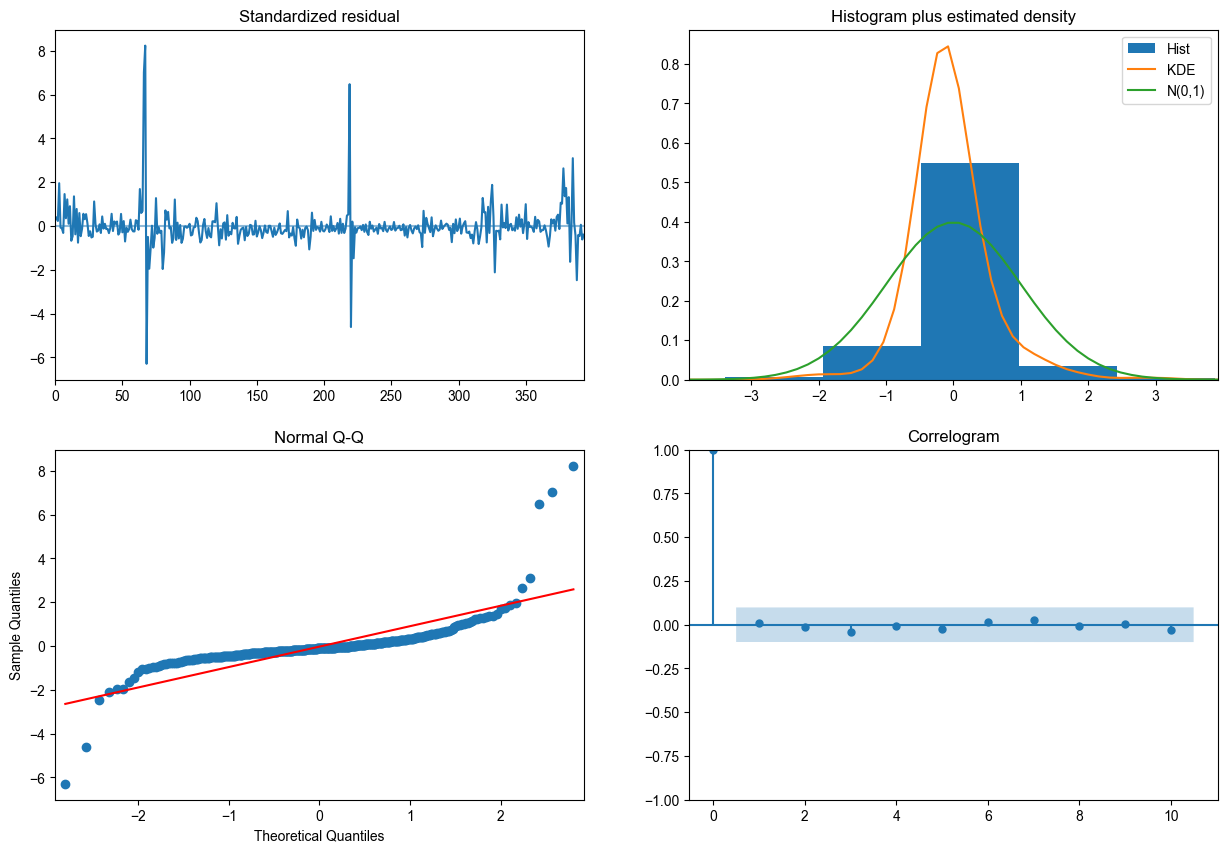

In [14]:
# 殘差診斷(原本 Auto-ARIMA 模型的)，這個只是拿來分析用，實際跑的是拿 ARIMA 的
auto_model.plot_diagnostics(figsize = (15, 10))
plt.show()

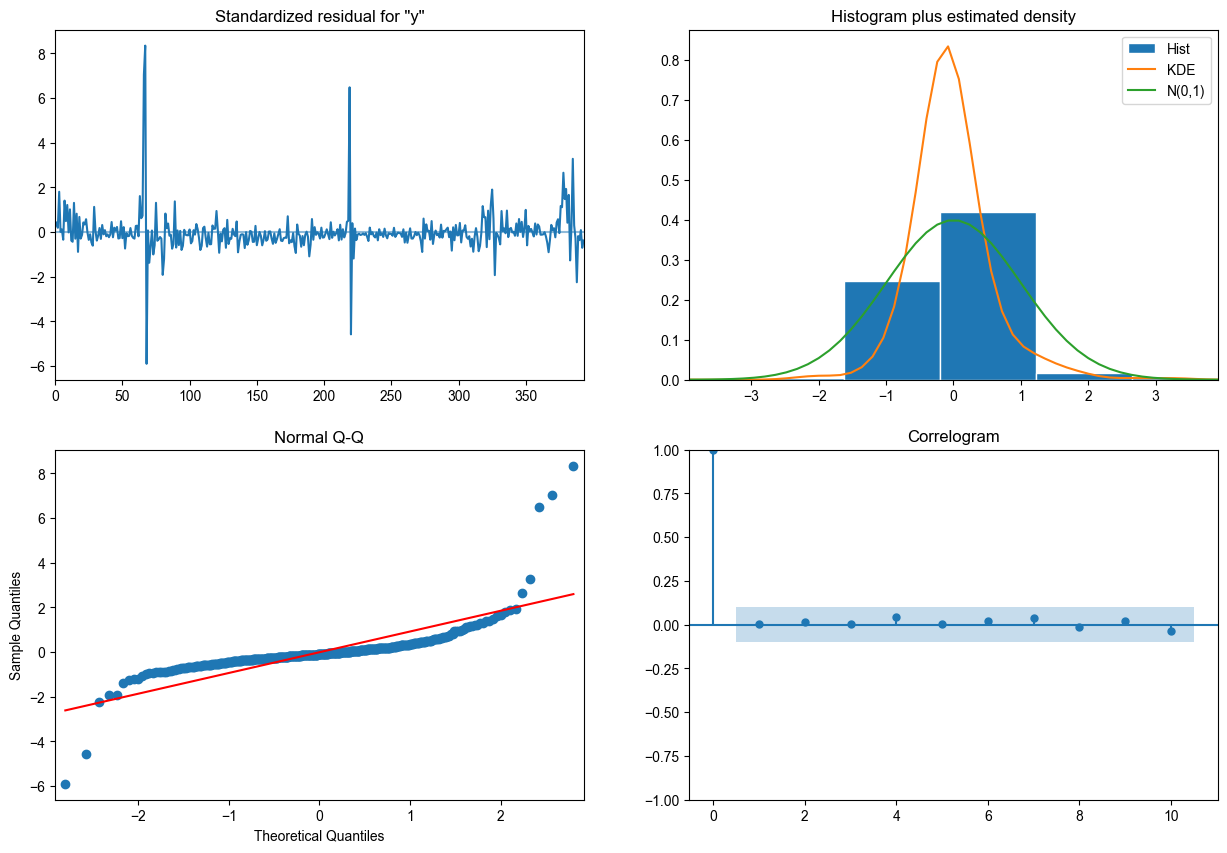

In [15]:
# 殘差診斷(原本 ARIMA 模型的)
model_summary_fit.plot_diagnostics(figsize = (15, 10))
plt.show()

## 白噪音檢定
藉由 Ljung-Box 定觀察 ARIMA 模型的殘差項是否為隨機變動，若檢定結果呈現白噪音(隨機)，則可以知道ARIMA模型的配適程度良好，便直接做預測；然而，若檢定結果呈現誤差項目並非白噪音，則需要用 `GARCH 模型找出誤差項中的變異數解釋變量`。

+ lb_stat : 這是 Ljung-Box 檢驗的檢驗統計量，用於檢查序列的自相關性，值越高表示序列具有較強的自相關性。
+ lb_pvalue : 這是對應於 Ljung-Box 統計量的 p 值，`用於檢驗零假設，即序列是白噪聲`，p 值小於 0.05（或選擇的顯著性水平）表示可以拒絕零假設，即序列可能具有顯著的自相關性，不是白噪聲。

In [16]:
lb_pvalue, white_noise_arima = arima.arima_acorr_ljungbox(arima_resid, training_window)

print('↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓') 
white_noise_arima

# Ljung-Box 檢驗
 H0: 誤差項為白噪音，資料是隨機的
 H1: 誤差項不是白噪音

誤差項 (P-value >= 0.05)，不能拒絕原假設(H0 成立)，殘差 "是" 白噪聲，代表殘差項目中沒有其他解釋變量可以提取，可直接使用 ARIMA 檢驗，理論上就可以停了
↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓


,lb_stat,lb_pvalue
14,4.188634,0.99422


## ARCH Effect 檢定

In [17]:
arch_test_result = arima.arima_het_arch(arima_resid, training_window)

# ARCH Effect 檢定
 H0: 資料中不存在 ARCH 效應
 H1: 資料中存在 ARCH 效應

殘差的方差 (P-value <= 0.05)，拒絕原假設，存在顯著的 ARCH 效應，需要進一步使用 GARCH
↓↓↓↓ ARCH 檢驗結果 ↓↓↓↓
ARCH 檢驗統計量: 179.88640619990107
p 值: 6.827521213406688e-31
F 統計量: 23.383524357385696
F 統計量的 p 值: 1.1158498921742055e-42


# 顯示預測圖表

# 顯示預測圖表


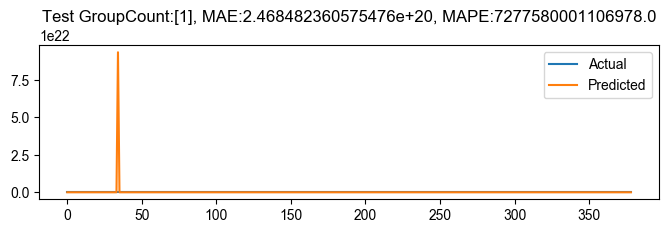

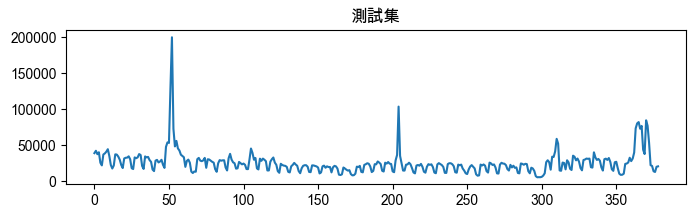

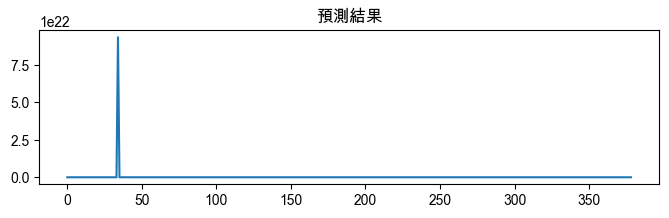

In [18]:
title = f'Test {fieldName}:{predict_types}, MAE:{round(mae, 5)}, MAPE:{round(mape, 5)}'

arima.show_predict_chart(
    eval_df,   
    actual = test_acts,
    predict = predictions,
    title = title
)

plt.figure(figsize=(8, 2))
plt.plot(test_acts, label='Actual')
plt.title('測試集')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(predictions)
plt.title('預測結果')
plt.show()

# 儲存結果

In [19]:
arima.save_json_file(
    result_file_name, 
    label = fieldName,
    predicteds = predict_types,
    best_p = best_p,
    best_d = best_d,
    best_q = best_q,
    best_aic = best_aic,
    best_ar_pvalue = best_ar_pvalue,
    best_ma_pvalue = best_ma_pvalue,
    mae_test = mae,
    mape_test = mape, 
    mse_test = mse,
    rmse_test = rmse,
    r_square_test = r_square,
    lb_pvalue = lb_pvalue,
    arch_pvalue = arch_test_result[1]
) 

# 儲存評估結果到 JSON 檔案
{'label': 'GroupCount', 'predicteds': [1], 'arima_p': 8, 'arima_d': 1, 'arima_q': 10, 'aic': 8457.500335518098, 'test_mae': 2.468482360575476e+20, 'test_mape': 7277580001106978.0, 'test_mse': 2.309400557334992e+43, 'test_rmse': 4.805622287836397e+21, 'test_r_square': -8.417566898914519e+34, 'ar_pvalue': '0.4684407019', 'ma_pvalue': '0.1811016251', 'lb_pvalue': 0.9942203422835486, 'arch_pvalue': 6.827521213406688e-31}
儲存評估結果到 ARIMA/_Model/GroupCount_data1.result.json
